### Import libraries and read in file

In [194]:
# import libs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# models and stuff
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [195]:
# read in file and define some useful column groupings
# elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
elec_w_weather_path = '/Users/ian.myjer/repos/gafp/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [196]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','office','outside_plug','entertainment','utility_room','unmetered','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

## Features

In [329]:
def feature_creation(df):
    # starting features
    feature_cols = ['main_house_total','Temp (C)']
    
    # possible spreading feature
#     df['mht_squared'] = df['main_house_total']**2
#     feature_cols.append('mht_squared')
    
    # time-based features
    df['hour'] = df.index.hour
    feature_cols.append('hour')

    # main house power percentage change and diff
    for interval in [1,3,5,9,15]:
        df['mht_pct_'+str(interval)] = df['main_house_total'].pct_change(interval).fillna(0).replace(np.inf,1000)
        df['mht_diff_'+str(interval)] = df['main_house_total'].diff(periods=interval).fillna(0)
        feature_cols.append('mht_pct_'+str(interval))
        feature_cols.append('mht_diff_'+str(interval))
    
    # exponential weighted mean
    for t in [15,30,45]:
        df['ewm_mean_'+str(t)] = df['main_house_total'].ewm(span=t).mean()
        feature_cols.append('ewm_mean_'+str(t))
        
    # rolling stats
    for time_val in [15,30,45]:
        df['rolling_sum_'+str(time_val)] = df['main_house_total'].rolling(time_val).sum().fillna(0)
        df['rolling_mean_'+str(time_val)] = df['main_house_total'].rolling(time_val).mean().fillna(0)
        df['rolling_max_'+str(time_val)]  = df['main_house_total'].rolling(time_val).max().fillna(0)
        df['rolling_min_'+str(time_val)]  = df['main_house_total'].rolling(time_val).min().fillna(0)
        df['rolling_median_'+str(time_val)]  = df['main_house_total'].rolling(time_val).median().fillna(0)
        df['rolling_skew_'+str(time_val)]  = df['main_house_total'].rolling(time_val).skew().fillna(0)
        df['rolling_kurtosis_'+str(time_val)]  = df['main_house_total'].rolling(time_val).kurt().fillna(0)
        df['rolling_corr_'+str(time_val)]  = df['main_house_total'].rolling(time_val).corr().fillna(0)
        df['rolling_cov_'+str(time_val)]  = df['main_house_total'].rolling(time_val).cov().fillna(0)
        feature_cols.append('rolling_sum_'+str(time_val))
        feature_cols.append('rolling_mean_'+str(time_val))
        feature_cols.append('rolling_max_'+str(time_val))
        feature_cols.append('rolling_min_'+str(time_val))
        feature_cols.append('rolling_median_'+str(time_val))
        feature_cols.append('rolling_cov_'+str(time_val))
#         # not important for rolling features
#         feature_cols.append('rolling_skew_'+str(time_val))
#         feature_cols.append('rolling_kurtosis_'+str(time_val))
#         feature_cols.append('rolling_corr_'+str(time_val))
  
    # Ideas
    # exponential things
    # multiply things by each other
    # rolling stats on calculated fields


    return feature_cols

## Modelling Functions

In [198]:
def tts(X,y,percent=0.66):
    train_size = int(len(X) * percent)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(X)]
    return X_train, X_test, y_train, y_test

In [199]:
def tts_small(X,y,first_split=0.33,second_split=0.66):
    train_size = int(len(X) * first_split)
    test_size = int(len(X) * second_split)
    X_train, X_test = X[0:train_size], X[train_size:test_size]
    y_train, y_test = y[0:train_size], y[train_size:test_size]
    return X_train, X_test, y_train, y_test

In [200]:
def model_chooser(model_type,X_train,X_test,y_train,n_estimators=10,max_features='auto'):
    if model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'logistic_regression':
        model = LogisticRegression()
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'extra_trees':
        model = ExtraTreesClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'ada_boost':
        model = AdaBoostClassifier(random_state=42,n_estimators=n_estimators)
    elif model_type == 'gradient_boost':
        model = GradientBoostingClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    else:
        model = None

    # fit and predict on model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    return model, y_pred, y_pred_proba

In [201]:
def print_accuracies(lbl,y_test,y_pred,y_pred_proba):
    print(lbl)
    # Predict appliances are always OFF
    y_null = np.zeros(len(y_test))
    print('Null Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_null)))

    # total accuracy
    print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('Log Loss: {:0.4f}'.format(metrics.log_loss(y_test,y_pred_proba)))

    # binary accuracy
    print('Accuracy Score 1s: {:0.4f}'.format(metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1])))
    print('Accuracy Score 0s: {:0.4f}'.format(metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0])))
    
    # confusion matrix
    print(metrics.confusion_matrix(y_test,y_pred))

In [202]:
def save_accuracies(lbl,model_type,y_test,y_pred,y_pred_proba):
    dct = {}
    y_null = np.zeros(len(y_test))
    dct[model_type+'_null_accuracy'] = metrics.accuracy_score(y_test, y_null)
    dct[model_type+'_total_accuracy'] = metrics.accuracy_score(y_test, y_pred)
    dct[model_type+'_log_loss'] = metrics.log_loss(y_test,y_pred_proba)
    dct[model_type+'_accuracy_1'] = metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1])
    dct[model_type+'_accuracy_0'] = metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0])
    return dct                                  

## Classify max appliance

In [320]:
# find and map max appliance
df['max_power'] = df[power_cols].max(axis=1)
df['col_max_row'] = df[power_cols].idxmax(axis=1)
df['col_max_row_remapped'] = df['col_max_row'].map(dict(zip(power_cols,range(len(power_cols)+1))))

# check if it's right 
mapping = dict(zip(power_cols,range(len(power_cols)+1)))
print(mapping)

{'north_br': 0, 'south_br': 1, 'basement': 2, 'dryer': 3, 'washer': 4, 'dining_room': 5, 'dishwasher': 6, 'workbench': 7, 'security_system': 8, 'refrigerator': 9, 'furnace_fan': 10, 'garage': 11, 'heat_pump': 12, 'dhw_heater': 13, 'office': 14, 'outside_plug': 15, 'entertainment': 16, 'utility_room': 17, 'unmetered': 18, 'oven': 19}


In [330]:
feature_cols = feature_creation(df)
lbl = 'col_max_row_remapped'
model_type = 'random_forest'

X = df[feature_cols]
y = df[lbl]

X_train, X_test, y_train, y_test = tts(X,y)

model, y_pred, y_pred_proba = model_chooser(model_type,X_train,X_test,y_train,n_estimators=100,max_features='auto')

In [331]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [332]:
# print column mapping as reference
print(mapping)

{'north_br': 0, 'south_br': 1, 'basement': 2, 'dryer': 3, 'washer': 4, 'dining_room': 5, 'dishwasher': 6, 'workbench': 7, 'security_system': 8, 'refrigerator': 9, 'furnace_fan': 10, 'garage': 11, 'heat_pump': 12, 'dhw_heater': 13, 'office': 14, 'outside_plug': 15, 'entertainment': 16, 'utility_room': 17, 'unmetered': 18, 'oven': 19}


In [333]:
# null accuracy
most_common_val = y_test.value_counts(sort=True).head(1).index[0]
y_null = np.ones(len(y_test))*most_common_val

# print accuracies and other shit
print('Null Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_null)))
print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
cm = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred))
pd.concat([cm], keys=['Actual'])

Null Accuracy Score: 0.3801
Total Accuracy Score: 0.8004
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       0.84      0.03      0.05      7156
          2       0.66      0.53      0.59     19684
          3       0.93      0.96      0.95      5109
          4       0.68      0.04      0.08      2507
          6       0.86      0.57      0.69      5788
          7       0.00      0.00      0.00         7
          8       0.00      0.00      0.00         1
          9       0.67      0.73      0.70     45071
         10       0.93      0.85      0.89    107894
         11       0.00      0.00      0.00        27
         12       0.93      0.96      0.94     23564
         14       0.00      0.00      0.00       197
         16       0.39      0.00      0.00      3252
         17       0.00      0.00      0.00         0
         18       0.75      0.88      0.81    135801
         19       0.76      0.47      0.5

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0    1      2     3    4     5   6   7      8      9   10     11  \
Actual 0    0    0      0     0    0     2   0   0      0      0   0      0   
       1    0  179      0     0    1     0   0   0   1359   2135   0      0   
       2    0    0  10488    28    8    63   0   0     14      0   0      0   
       3    0    0     14  4928    0     0   0   0      0      0   0      0   
       4    0    0     97    15  108    49   0   0    148     54   0      0   
       5    0    0    191     0   10  3305   0   0     61      0   0     30   
       6    0    0      0     0    0     0   0   0      0      0   0      0   
       7    0    0      0     0    0     0   0   0      0      0   0      0   
       8    0    7    133     7    1    29   0   0  32981    650   0     15   
       9    0   23      1     0    2     0   0   0   7479  91743   0      0   
       10   0    0      2     0    0     0   0   0      3     10   0      0   
       11   0    0      0    42    0    11   0   0      1      0   0  22614   
       12   0    0      8     0    0     2   0   0     41     36   0      0   
       13   0    0   1387     0    1     9   0   0     57      4   0      0   
       14   0    0      0     0    0     0   0   0      0      0   0      0   
       15   0    4   3464   125   29   370   0   0   7321   3627   0   1756   
       16   0    0      0   162    0     0   0   0      3      0   0     22   

           12  13  14      15   16  
Actual 0    0   0   0      10    0  
       1    0   0   0    3482    0  
       2    0   0   0    9083    0  
       3    0   0   0     165    2  
       4    0   1   0    2035    0  
       5    0   0   0    2191    0  
       6    0   0   0       7    0  
       7    0   0   1       0    0  
       8    1   0   0   11247    0  
       9    0   2   0    8644    0  
       10   0   0   0      12    0  
       11   0   0   0     787  109  
       12   0   1   0     109    0  
       13   0   7   0    1787    0  
       14   0   0   0       0    0  
       15   0   7   0  119035   63  
       16   0   0   0     443  566

In [334]:
fi = pd.DataFrame(model.feature_importances_
                  ,index=feature_cols
                  ,columns=['feature_importance']).sort_values(by='feature_importance',ascending=False)
fi
# cols_to_drop = list(fi.loc['hour':,:].index)
# fi.drop(cols_to_drop,axis=0,inplace=True)
# cols_to_keep = list(fi.index)

,feature_importance
main_house_total,0.132161
test,0.077662
test4,0.062915
rolling_min_15,0.044674
test3,0.039578
mht_diff_9,0.032542
mht_diff_15,0.030756
ewm_mean_15,0.030594
rolling_max_15,0.030191
mht_pct_15,0.029545


In [236]:
lbl = 'col_max_row_remapped'
model_type = 'random_forest'

X = df[cols_to_keep]
y = df[lbl]

X_train, X_test, y_train, y_test = tts(X,y)

model, y_pred, y_pred_proba = model_chooser(model_type,X_train,X_test,y_train,n_estimators=100,max_features='auto')

In [241]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [ ]:
# total accuracy
most_common_val = y_test.value_counts(sort=True).head(1).index[0]
y_null = np.ones(len(y_test))*most_common_val
print('Null Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_null)))
print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
cm = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred))
pd.concat([cm], keys=['Actual'])

## Try to figure out why predictions are wrong

In [313]:
# create comparison dataframe
foo = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
bar = pd.concat([foo,X_test],axis=1)
bar = bar.merge(df[power_cols],left_index=True,right_index=True,how='left')

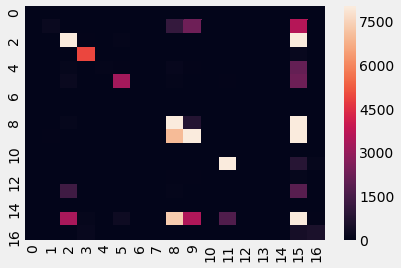

In [314]:
import seaborn as sns
sns.heatmap(cm,vmax=8000);

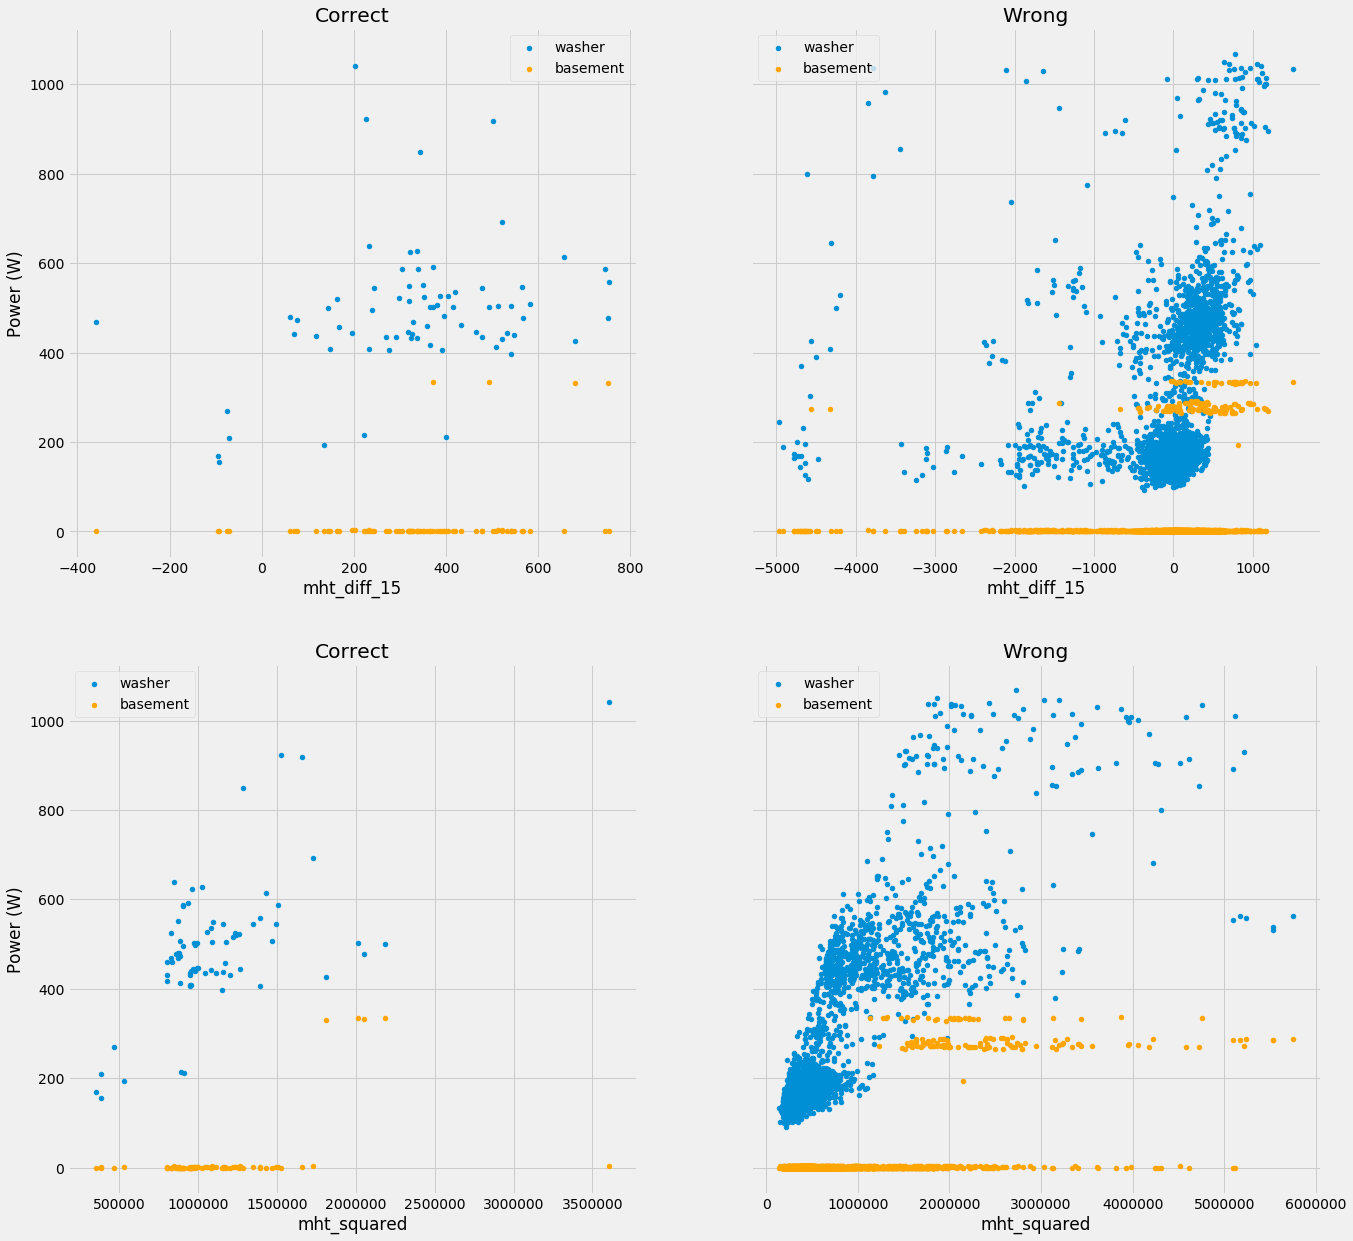

In [316]:
lbl1 = 'washer'
lbl2 = 'basement'

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,20),sharey=True)
xlbl = 'mht_diff_15'
mask = (y_test==mapping[lbl1])&(y_pred==mapping[lbl1])
bar[mask].plot(kind='scatter',x=xlbl,y=lbl1,linewidth=1,label=lbl1,legend=True,ax=axes[0,0]);
bar[mask].plot(kind='scatter',x=xlbl,y=lbl2,linewidth=1,label=lbl2,legend=True,color='Orange',ax=axes[0,0]);
axes[0,0].set_title('Correct');
axes[0,0].set_ylabel('Power (W)');

mask = (y_test==mapping[lbl1])&(y_pred!=mapping[lbl1])
ax = bar[mask].plot(kind='scatter',x=xlbl,y=lbl1,linewidth=1,label=lbl1,legend=True,ax=axes[0,1]);
bar[mask].plot(kind='scatter',x=xlbl,y=lbl2,linewidth=1,label=lbl2,legend=True,color='Orange',ax=axes[0,1]);
axes[0,1].set_title('Wrong');
axes[0,1].set_ylabel('Power (W)');

xlbl = 'mht_squared'
mask = (y_test==mapping[lbl1])&(y_pred==mapping[lbl1])
bar[mask].plot(kind='scatter',x=xlbl,y=lbl1,linewidth=1,label=lbl1,legend=True,ax=axes[1,0]);
bar[mask].plot(kind='scatter',x=xlbl,y=lbl2,linewidth=1,label=lbl2,legend=True,color='Orange',ax=axes[1,0]);
axes[1,0].set_title('Correct');
axes[1,0].set_ylabel('Power (W)');

mask = (y_test==mapping[lbl1])&(y_pred!=mapping[lbl1])
ax = bar[mask].plot(kind='scatter',x=xlbl,y=lbl1,linewidth=1,label=lbl1,legend=True,ax=axes[1,1]);
bar[mask].plot(kind='scatter',x=xlbl,y=lbl2,linewidth=1,label=lbl2,legend=True,color='Orange',ax=axes[1,1]);
axes[1,1].set_title('Wrong');
axes[1,1].set_ylabel('Power (W)');


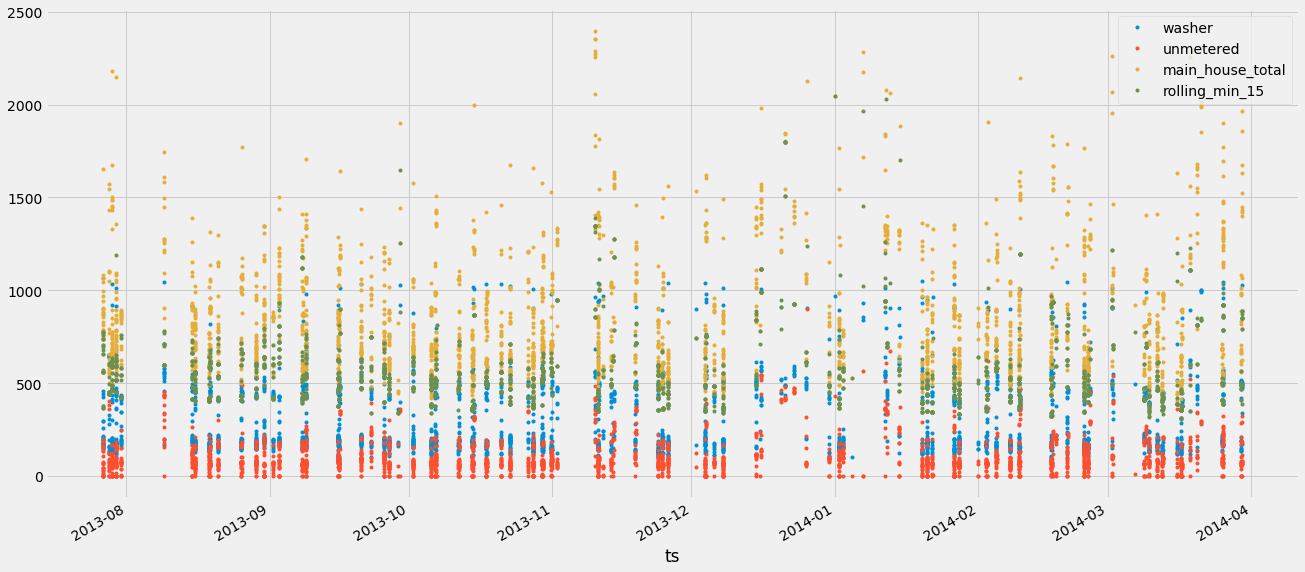

In [268]:
lbl = ['washer','unmetered','main_house_total','rolling_min_15']
mask = (y_test==4)&(y_pred!=4)
bar[lbl][mask].plot(linewidth=1,label='wrong',style='.',legend=True,figsize=(20,10));
# mask = (y_test==4)&(y_pred==4)
# bar[lbl][mask].plot(linewidth=1,label='correct',legend=True);

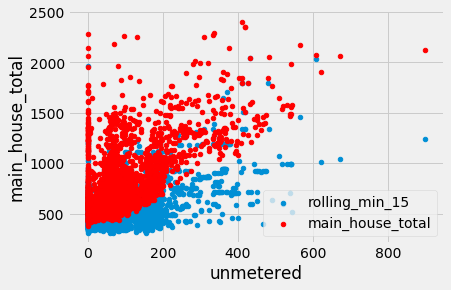

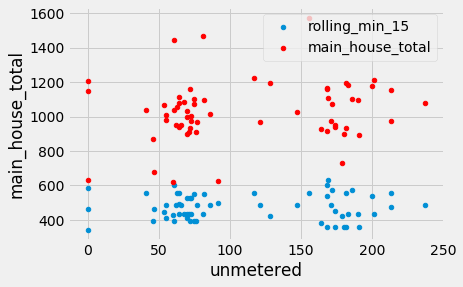

In [264]:
lbl1 = 'rolling_min_15'
lbl2 = 'main_house_total'
xlbl = 'unmetered'
mask = (y_test==mapping['washer'])&(y_pred!=mapping['washer'])
ax = bar[mask].plot(kind='scatter',x=xlbl,y=lbl1,linewidth=1,label=lbl1,legend=True);
bar[mask].plot(kind='scatter',x=xlbl,y=lbl2,linewidth=1,label=lbl2,legend=True,color='Red',ax=ax);



lbl1 = 'rolling_min_15'
lbl2 = 'main_house_total'
xlbl = 'unmetered'
mask = (y_test==mapping['washer'])&(y_pred==mapping['washer'])
ax = bar[mask].plot(kind='scatter',x=xlbl,y=lbl1,linewidth=1,label=lbl1,legend=True);
bar[mask].plot(kind='scatter',x=xlbl,y=lbl2,linewidth=1,label=lbl2,legend=True,color='Red',ax=ax);

6

## Predict Categorical Max

In [ ]:
remap = {'dishwasher':1,'dryer':1,'washer':1,'oven':1,
         'dhw_heater':3,'refrigerator':3,
         'furnace_fan':4,'heat_pump':4,
         'basement':2,'dining_room':2,'entertainment':2,'garage':2,'south_br':2,'north_br':2,'security_system':2,
        'utility_room':2,'workbench':2,'outside_plug':2,'unmetered':2,'office':2}

In [ ]:
df['max_power'] = df[power_cols].max(axis=1)
df['col_max_row'] = df[power_cols].idxmax(axis=1)
df['col_max_row_categorized'] = df['col_max_row'].map(remap)

In [ ]:
feature_cols = feature_creation(df)
lbl = 'col_max_row_categorized'
model_type = 'random_forest'

X = df[feature_cols]
y = df[lbl]

X_train, X_test, y_train, y_test = tts(X,y)

model, y_pred, y_pred_proba = model_chooser(model_type,X_train,X_test,y_train,n_estimators=100,max_features='auto')

In [ ]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [ ]:
y_test.value_counts()

In [ ]:
from collections import Counter
Counter(y_pred)

In [ ]:
# total accuracy
most_common_val = y_test.value_counts(sort=True).head(1).index[0]
y_null = np.ones(len(y_test))*most_common_val
print('Null Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_null)))
print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Log Loss: {:0.4f}'.format(metrics.log_loss(y_test,y_pred_proba)))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test,y_pred))


In [ ]:
pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False)

## Try to figure out why predictions are wrong

In [ ]:
foo = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
bar = pd.concat([foo,X_test],axis=1)
bar[bar.y_test!=bar.y_pred]

## Attempt to use Pipeline

In [ ]:
feature_cols = feature_creation(df)
lbl = 'col_max_row_categorized'

X = df[feature_cols]
y = df[lbl]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
# potentially useful
# http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/
# https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sci

In [ ]:
# create a pipeline
pipe = make_pipeline(RandomForestClassifier(random_state=42))

# search for an optimal hyperparameters
ne = list(range(30,150,30))
mf = list(range(1,X.shape[1]-1,5))

# train test split time series
tscv = TimeSeriesSplit(n_splits=2).split(X)

# create a param grid
param_grid = dict(randomforestclassifier__n_estimators=ne
                 , randomforestclassifier__max_features = mf)

# create a grid search
rs = RandomizedSearchCV(pipe, param_grid, cv=tscv, scoring='accuracy', n_iter = 10, n_jobs=-1,)

# fit the grid
rs.fit(X, y)

# view the best_score_ and best_params_
print(rs.best_score_)
print(rs.best_params_)